In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [4]:
# Constants
DATASET_DIR = 'dataset'
CATEGORIES = ["leaf fossils", "leaves"]
IMG_SIZE = 200  # Resize all images to 200x200

In [5]:
# Function to load and preprocess data
def load_and_preprocess_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATASET_DIR, category)
        class_num = CATEGORIES.index(category)  # Label: 0 for "leaf fossils", 1 for "leaves"
        
        for img in os.listdir(path):
            try:
                # Load image in grayscale
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Resize image
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                # Normalize pixel values (0-255 -> 0-1)
                new_array = new_array / 255.0
                # Add image and label to data
                data.append([new_array, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")
    
    return data

In [6]:
# Load and preprocess data
training_data = load_and_preprocess_data()

Error processing image all.csv: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [7]:
# Shuffle data
import random
random.shuffle(training_data)

In [8]:
# Split features (X) and labels (y)
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

In [9]:
# Convert to numpy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Add channel dimension for grayscale
y = np.array(y)

In [10]:
# One-hot encode labels
y = to_categorical(y, num_classes=len(CATEGORIES))

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
dataset_without_augmantation = "leaves"

In [12]:
import pickle
with open("X_train.pickle", "wb") as f:
    pickle.dump(X_train, f)
with open("X_test.pickle", "wb") as f:
    pickle.dump(X_test, f)
with open("y_train.pickle", "wb") as f:
    pickle.dump(y_train, f)
with open("y_test.pickle", "wb") as f:
    pickle.dump(y_test, f)


In [15]:
# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1684, 200, 200, 1)
y_train shape: (1684, 2)
X_test shape: (422, 200, 200, 1)
y_test shape: (422, 2)


In [16]:
# ResNet Model (using pre-trained ResNet50)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model

In [17]:
# Build the full model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(3, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 1), padding='same'),  # Convert grayscale to RGB
    tf.keras.layers.ReLU(),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(CATEGORIES), activation='softmax')
])

c:\Users\LapTop\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

c:\Users\LapTop\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.8311 - loss: 0.6263 - val_accuracy: 0.9313 - val_loss: 0.3006
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.8953 - loss: 0.3574 - val_accuracy: 0.9313 - val_loss: 0.2531
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.9022 - loss: 0.3321 - val_accuracy: 0.9313 - val_loss: 0.2735
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.8944 - loss: 0.3579 - val_accuracy: 0.9313 - val_loss: 0.2549
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8933 - loss: 0.3621 - val_accuracy: 0.9313 - val_loss: 0.2490
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.8904 - loss: 0.3467 - val_accuracy: 0.9313 - val_loss: 0.2336
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.8876 - loss: 0.3278 - val_accuracy: 0.9313 - val_loss: 0.1836
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.8828 - loss: 0.2680 - val_accuracy: 0.9313 - v

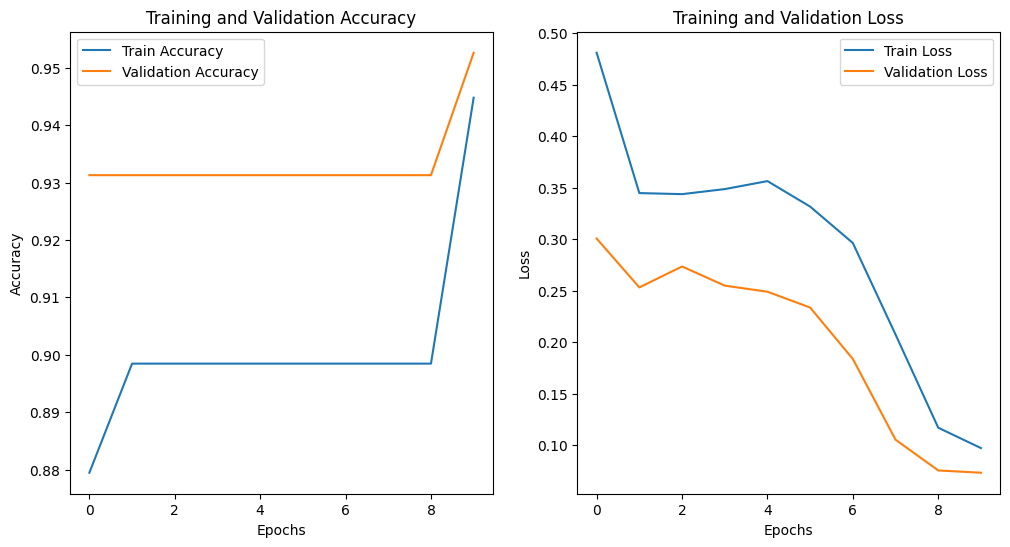

In [19]:
# Plotting training accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


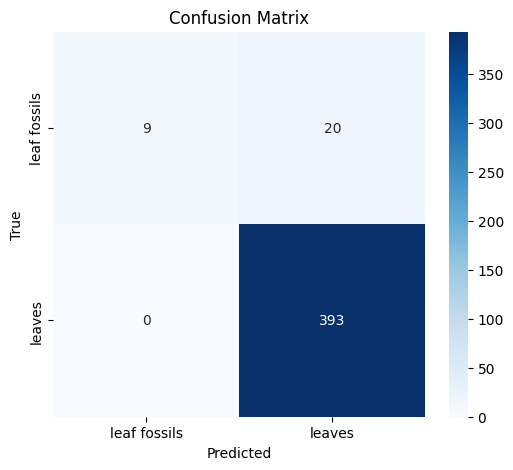

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
from sklearn.metrics import classification_report

# Classification Report (Precision, Recall, F1-score)
print(classification_report(y_true, y_pred_classes, target_names=CATEGORIES))

              precision    recall  f1-score   support

leaf fossils       1.00      0.31      0.47        29
      leaves       0.95      1.00      0.98       393

    accuracy                           0.95       422
   macro avg       0.98      0.66      0.72       422
weighted avg       0.95      0.95      0.94       422



In [28]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.9549
Recall: 0.9526
F1-Score: 0.9407


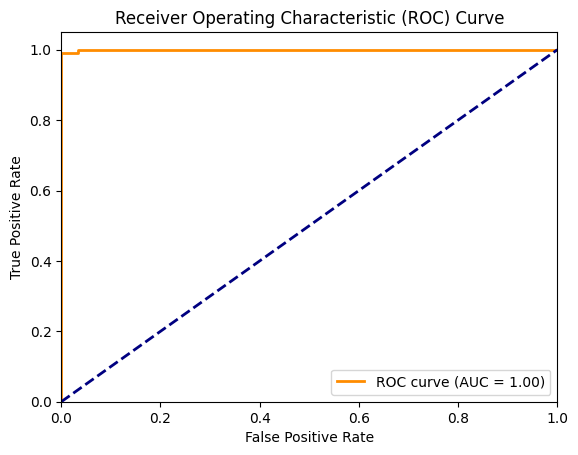

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# ROC and AUC curve
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])  # Class 1 is the positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
# Xception Model (using pre-trained Xception)
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # Freeze the base model

In [26]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.9124 - loss: 0.1327 - val_accuracy: 0.9194 - val_loss: 0.1317
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9551 - loss: 0.0886 - val_accuracy: 0.9336 - val_loss: 0.1299
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.9687 - loss: 0.0906 - val_accuracy: 0.9502 - val_loss: 0.1266
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.9848 - loss: 0.0775 - val_accuracy: 0.9621 - val_loss: 0.1086
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9862 - loss: 0.0671 - val_accuracy: 0.9621 - val_loss: 0.1169


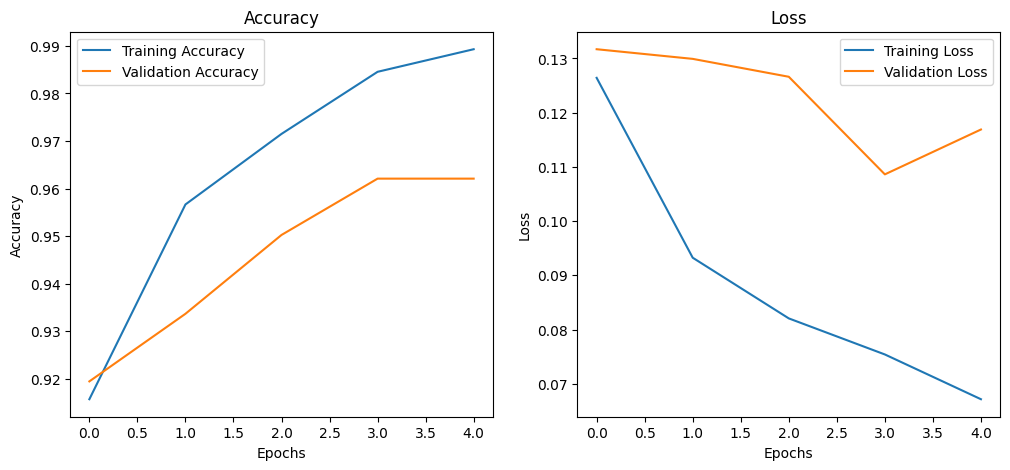

In [29]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
Classification Report:
              precision    recall  f1-score   support

leaf fossils       1.00      0.66      0.79        47
      leaves       0.96      1.00      0.98       375

    accuracy                           0.96       422
   macro avg       0.98      0.83      0.89       422
weighted avg       0.96      0.96      0.96       422



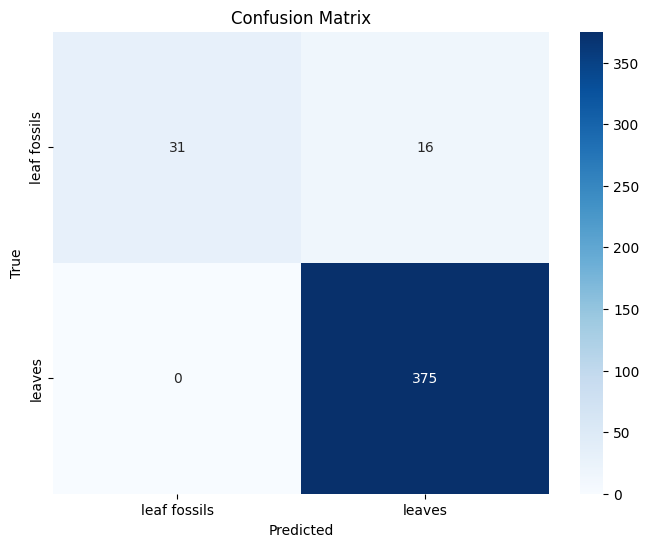

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CATEGORIES))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

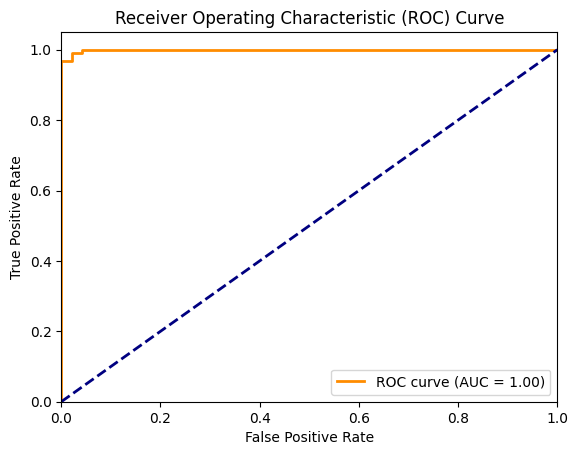

In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# ROC and AUC curve
fpr, tpr, _ = roc_curve(y_true_classes, y_pred[:, 1])  # Class 1 is the positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1-score: 0.96


In [59]:
IMG_SIZE

200

In [ ]:
# Xception Model (using pre-trained Xception)
dense_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3), classes=2)

dense_model.trainable = True  # Freeze the base model

for layer in dense_model.layers[-100:]:
    layer.trainable = False
# dense_model.summary()

In [60]:
from tensorflow.keras import models, layers

dense_model_f = models.Sequential([
    dense_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2), 
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax'),

])

In [61]:
dense_model_f.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
history_dense = dense_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=5, validation_data=(X_test, y_test))

Epoch 1/5


c:\Users\LapTop\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv1_conv" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 206, 206, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 200, 200, 1), dtype=float32)
  • training=True
  • mask=None